### Preliminaries
<small>This section includes package imports and helper functions.


In [ ]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import scipy.stats as stats

from scipy.special import gamma
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.stats import t
from numba import njit
import seaborn as sns
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT = '/content/drive/MyDrive/EPINN_Poisson'
MODEL_DIR = f'{ROOT}/models'

#### Utility functions

In [ ]:
class FCN(nn.Module):

    """
      Multilayer perceptron model, with outputs corresponding to targets of Deep Evidential Regression

      Args:
          N_INPUT : number of independent variables in the ODE
          N_HIDDEN : number of neurons per hidden layer
          N_LAYERS : number of hidden layers

      Returns:
          alpha, beta, nu, gamma : evidential deep learning-based outputs, with gamma being the mean and the
                                   rest related to the uncertainty

    """

    def __init__(self, N_INPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.output_alpha = nn.Linear(N_HIDDEN, 1)
        self.output_beta = nn.Linear(N_HIDDEN, 1)
        self.output_nu = nn.Linear(N_HIDDEN, 1)
        self.output_gamma = nn.Linear(N_HIDDEN, 1)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        softplus = nn.Softplus()
        alpha = 1.1 + softplus(self.output_alpha(x))
        beta = softplus(self.output_beta(x))
        nu = 0.5+softplus(self.output_nu(x))
        gamma = self.output_gamma(x)

        return alpha, beta, nu, gamma


def evidential_data_loss(u_obs, gamma, nu, alpha, beta ):

    """
    Loss function of Evidential Deep Learning (EDL)

    Args:
        u_obs : observed target
        alpha, beta, nu, gamma : evidential model's outputs with 'gamma' being mean

    Returns:
        value of EDL loss -- this is the main loss term governing target prediction with uncertainty estimates.
    """

    twoBlambda = 2*(beta)*(1+nu)

    nll = 0.5*torch.log(torch.pi/(nu))  \
        - alpha*torch.log(twoBlambda)  \
        + (alpha+0.5) * torch.log(nu*(u_obs-gamma)**2 + twoBlambda)  \
        + torch.lgamma(alpha)  \
        - torch.lgamma(alpha+0.5)

    return torch.mean(nll)



def CI_calculation(interval_CI, alpha, beta, nu, gamma):

    """
    Function that computes the confidence interval for the model's output

    Args:
        interval_CI : confidence interval, e.g. 0.95 for 95% interval
        alpha, beta, nu, gamma : evidential model's outputs with 'gamma' being mean

    Returns:
        lower bound of the confidence interval assuming mean centered at 0
    """
    from scipy.stats import t
    scale_sq = beta*(1+nu)/(alpha*nu)
    scale = np.sqrt(scale_sq)

    I_delta = []

    for i in range(len(alpha)):
      a,b= t.interval(interval_CI, df=2*alpha[i], loc=0, scale=scale[i])
      I_delta.append(a)

    return np.array(I_delta)



@njit
def F_njit_ind(x_0, var_0, x_p, grad2_L):

  """
  This defines the R^2_i function for the Poisson equation

  Args:
      x_0, var_0 : parameters of the Poisson equation to be inferred
      x_p, grad2_L : the independent variable and second derivative of the target w.r.t. x_p

  Returns:
      the R^2_i function for the Poisson equation evaluated at each point of x_p
  """

  resi_loss = (grad2_L + np.exp(-((x_p - x_0)**2)/(2*var_0)) )**2

  return resi_loss



@njit
def compute_z_array(x_vec, var_vec, x_p, grad2_L):

    """
    Function computing R^2_i for every value of the unknown parameters

    Args:
    x_vec, var_vec : parameters of the Poisson equation to be inferred
    x_p, grad2_L : the independent variable and second derivative of the target w.r.t. x_p

    Returns:
      a 3D array of the R^2_i function for the Poisson equation: the first two dimensions pertaining to the two unknown parameters
      and the final dimension pertaining to x_p
    """

    I,J,M = len(x_vec),len(var_vec),len(x_p)
    Z = np.empty((I,J,M))
    for i in range(I):
      for j in range(J):
       Z[i,j,:]= F_njit_ind(x_vec[i], var_vec[j], x_p, grad2_L)
    return Z



@njit
def njit_marginal_ll(variance_R, resi_sum_array):

    """
    Computes the unnormalized likelihood function defined as the exponential of PDE residual

    Args:
        variance_R: variance parameter in the PDE residual (inverse of PDE residual loss weight)
        resi_sum_array: the PDE residual sum

    Returns:
        the unnormalized likelihood function

    """

    pdf_unnorm = np.exp(-1*((1/(2*variance_R))*resi_sum_array) )
    return pdf_unnorm



def kl_divergence_f(variance_array, resi_sum_array, p1_prior, p2_prior, epsilon ):

    """
    Computes the Kullback-Leibler divergence between the likelihood function and
    and the product of the prior functions for each unknown parameter.

    Args:
        variance_array: variance of the PDE likelihood function or the inverse of the loss weight for PDE residual
        resi_sum_array: the PDE residual (summed over all temporal points)
        p1_prior, p2_prior: prior density function for each parameter
        epsilon: regularization parameter

    Returns:
        KL divergence between the parameter prior and the likelihood function defined by
        the exponential of the PDE residual

    """

    q_vals = np.exp(-1*((1/(2*variance_array))*resi_sum_array) )
    Q_safe = q_vals/np.sum(q_vals)

    prior_pdf = (p1_prior[:, None] * p2_prior[None, :] )
    P_safe = prior_pdf/np.sum(prior_pdf)

    if epsilon > 0:
      Q_safe = np.clip(Q_safe, epsilon, 1.0)
      Q_safe = Q_safe / np.sum(Q_safe)
      P_safe = np.clip(P_safe, epsilon, 1.0)
      P_safe = P_safe / np.sum(P_safe)

    log_P_safe = np.log(P_safe)
    log_Q_safe = np.log(Q_safe)

    kl_div = np.sum(P_safe * (log_P_safe - log_Q_safe))

    return kl_div



def num_sol_poisson(s_mean, s_variance, N):

    """
    Generates a numerical solution to Poisson equation with Gaussian source

    Args:
        s_mean : Mean of the Gaussian source.
        s_variance : Variance of the Gaussian source
        N : Number of points in the domain [0,1] at which the solution is evaluated.

    Returns:
        The numerical solution to the Poisson equation with u = 0 at boundary points.

    """

    L = 1.0
    x = np.linspace(0, L, N)
    dx = x[1] - x[0]

    # Gaussian source term
    f = np.exp(- (x - s_mean)**2 / (2 * s_variance))

    # Finite difference matrix for -d^2u/dx^2
    main_diag = -2.0 * np.ones(N)
    off_diag = np.ones(N - 1)
    A = diags([off_diag, main_diag, off_diag], offsets=[-1, 0, 1]) / dx**2
    A = A.tocsr()

    # Removing first and last rows/cols to define the interior solution
    A_interior = A[1:-1, 1:-1]
    f_interior = f[1:-1]

    # Solve linear system
    u_interior = spsolve(A_interior, -f_interior)

    # Construct full solution, with Dirichlet BCs: u(0)=0, u(L)=0
    u = np.zeros_like(x)
    u[1:-1] = u_interior

    return u

### Dataset

In [ ]:
np.random.seed(40)
random_noise = np.concatenate((np.zeros(10),0.005*(np.random.rand(330)-0.5), np.zeros(10) ))
u_num_sol = num_sol_poisson(1/3, 0.02, 350) + random_noise

L = 1.0
x_total = np.linspace(0, L, 350)

np.random.seed(42)
permuted_indices = np.random.permutation(350)

val_indices = permuted_indices[:150]
train_indices = permuted_indices[150:]

val_data = u_num_sol[val_indices]           #validation data
train_data = u_num_sol[train_indices]       #training data

val_x = x_total[val_indices]
train_x = x_total[train_indices]

# Adding additional training data to impose Dirichlet boundary conditions
x_bc_left = np.zeros(20)
x_bc_right = np.ones(20)
x_train = np.concatenate((x_bc_left, train_x, x_bc_right))

u_bc_left = np.zeros(20)
u_bc_right = np.zeros(20)
u_train = np.concatenate((u_bc_left, train_data, u_bc_right))

sort_idx = np.argsort(x_train)
x_train = x_train[sort_idx]
u_train = u_train[sort_idx]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_train = torch.tensor(x_train, dtype=torch.float32)
x_train = x_train.view(-1,1).requires_grad_(True)
x_train = x_train.to(device)
u_train = torch.tensor(u_train, dtype=torch.float32)
u_train = u_train.view(-1,1).requires_grad_(True)
u_train = u_train.to(device)

val_x = torch.tensor(val_x, dtype=torch.float32)
val_x = val_x.view(-1,1).requires_grad_(True)
val_x = val_x.to(device)
val_data = torch.tensor(val_data, dtype=torch.float32)
val_data = val_data.view(-1,1).requires_grad_(True)
val_data = val_data.to(device)

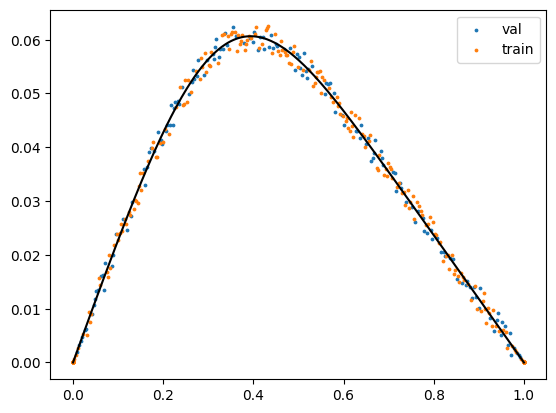

In [ ]:
u_exact_sol = num_sol_poisson(1/3, 0.02, 350)
plt.plot(x_total, u_exact_sol, 'k')
plt.scatter(val_x.detach().cpu().numpy(), val_data.detach().cpu().numpy(), s = 3, label='val')
plt.scatter(x_train.detach().cpu().numpy(), u_train.detach().cpu().numpy(), s = 3, label='train')
plt.legend()

### 1st training phase: data-fitting

In [ ]:
nn_I = FCN(1,16,2).to(device)

n_D = x_train.shape[0]

lr = 1e-4

loss_list = []
val_loss_list = []
optimizer = optim.Adam(list(nn_I.parameters()), lr=lr)

for epoch in range(200_001):

    optimizer.zero_grad()

    L_p_alpha, L_p_beta, L_p_nu, L_pred = nn_I(x_train)

    #-----Data Loss-----------------------------------------
    data_loss = n_D*evidential_data_loss(L_pred, u_train, L_p_nu, L_p_alpha, L_p_beta)
    L_t_alpha, L_t_beta, L_t_nu, L_t_pred = nn_I(val_x)
    val_loss = n_D*evidential_data_loss(L_t_pred, val_data, L_t_nu, L_t_alpha, L_t_beta)

    #-----Total loss----------------------------------------
    loss = data_loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.3e}, val_loss: {val_loss:.3e}")
        loss_list.append(loss.item())
        val_loss_list.append(val_loss.item())


Text(0, 0.5, 'Target variable $y$')

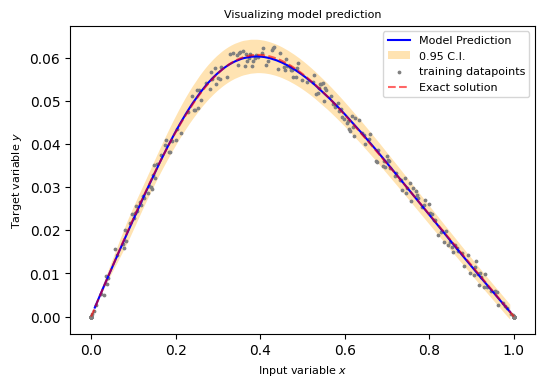

In [ ]:
#saving and visualising initial model prediction

#torch.save(nn_I.state_dict(), f'{MODEL_DIR}/ini_epinn_poisson.pth')
#torch.save({
#    'loss_list': loss_list,
#    'val_loss_list': val_loss_list
#       }, f'{MODEL_DIR}/ini_epinn_poisson_loss.pth')


Lp_alpha, Lp_beta, Lp_nu, L_pred = nn_I(val_x)

#-----defining quantities for plotting ---------------------------------------------
n_val_x = np.squeeze(val_x.detach().cpu().numpy())
n_val_y = np.squeeze(val_data.detach().cpu().numpy())

Lp_alpha = np.squeeze(Lp_alpha.detach().cpu().numpy())
Lp_beta = np.squeeze(Lp_beta.detach().cpu().numpy())
Lp_nu = np.squeeze(Lp_nu.detach().cpu().numpy())
L_pred = np.squeeze(L_pred.detach().cpu().numpy())

sort_idx = np.argsort(n_val_x)

n_val_x = n_val_x[sort_idx]
n_val_y = n_val_y[sort_idx]
Lp_alpha = Lp_alpha[sort_idx]
Lp_beta = Lp_beta[sort_idx]
Lp_nu = Lp_nu[sort_idx]
L_pred = L_pred[sort_idx]

interval_CI = 0.95
Llower = L_pred + CI_calculation(interval_CI, Lp_alpha, Lp_beta, Lp_nu, L_pred)
Lupper = L_pred - CI_calculation(interval_CI, Lp_alpha, Lp_beta, Lp_nu, L_pred)

n_x_train = np.squeeze(x_train.detach().cpu().numpy())
n_u_train = np.squeeze(u_train.detach().cpu().numpy())

#-----------------------------------------------------------------------------------

plt.figure(figsize=(6,4))
plt.plot(n_val_x, L_pred, color = 'b', label='Model Prediction')
plt.fill_between(n_val_x, Llower, Lupper, facecolor='orange', alpha=0.3, label = rf'{interval_CI} C.I.')
plt.scatter(n_x_train[:], n_u_train[:], c='gray',s=3, label="training datapoints")

plt.plot(x_total, u_exact_sol, 'r--', label="Exact solution",
         alpha=0.6)

plt.title(f"Visualizing model prediction", fontsize = 8)
plt.legend(loc = 'upper right', fontsize=8)
plt.xlabel(r"Input variable $x$",fontsize=8)
plt.ylabel(r"Target variable $y$", fontsize=8)



Text(0.5, 1.0, 'Error Calibration Plot')

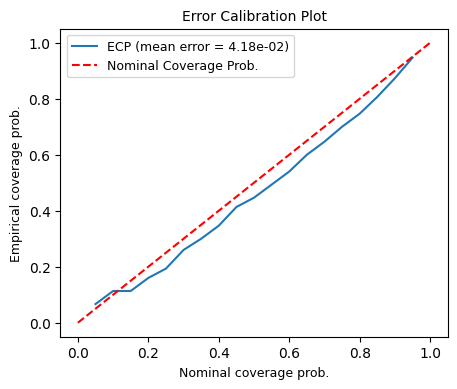

In [ ]:
#Empirical coverage probability

empirical_data = n_val_y

ecp_list = []
dis_list = []

for j in range(19):

  interval_CI = (j+1)*0.05

  neg_CI_delta = CI_calculation(interval_CI, Lp_alpha, Lp_beta ,
                                  Lp_nu, L_pred)

  acc=0
  for i in range(len(empirical_data)):
    if  np.abs(empirical_data[i] - L_pred[i])  < np.abs(neg_CI_delta[i]) :
      acc += 1

  empirical_ecp = acc/len(empirical_data)
  discrepancy = np.abs(empirical_ecp - interval_CI)

  dis_list.append(discrepancy)
  ecp_list.append(acc/len(empirical_data))

# ---------------------ecp vs ncp plot-----------------------------
plt.figure(figsize=(5,4))
plt.plot(np.arange(0.05, 1.0, 0.05), ecp_list, label=f'ECP (mean error = {np.mean(dis_list):.2e})')
plt.plot([0,1],[0,1],'r--', label='Nominal Coverage Prob.')
plt.legend(fontsize = 9)
plt.xlabel('Nominal coverage prob.', fontsize=9)
plt.ylabel('Empirical coverage prob.', fontsize = 9)
plt.title('Error Calibration Plot', fontsize=10)



### Intermediate phase: determining priors for 2nd training phase

In [ ]:
# parameter ranges
x0_vals = np.linspace(0.0, 1.0, 50)
var_vals = np.linspace(0.01, 0.06, 50)

# loading initial model
ini_nn_I = FCN(1,16,2).to(device)
ini_nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/ini_epinn_poisson.pth'))

##### Prior for the parameters

In [ ]:
msd_list = []

z_monte = np.linspace(0,1,300)
z_monte = torch.tensor(z_monte, dtype=torch.float32)
z_monte = z_monte.view(-1,1).requires_grad_(True)

Lp_alpha, Lp_beta, Lp_nu, L_pred = ini_nn_I(z_monte)
L_monte_pred = L_pred.detach().cpu().numpy()

for x0 in x0_vals:
  for var in var_vals:
    L_infer = num_sol_poisson(x0, var, 300)
    msd = np.sum((np.squeeze(L_monte_pred) - L_infer)**2)
    msd_list.append(msd)

msd_var = np.mean(msd_list)

mse = np.exp(-0.5*np.array(msd_list)/msd_var)

prob_grid = mse.reshape(len(x0_vals), len(var_vals))

row, col = np.unravel_index(np.argmax(mse), [50,50])

x0_prior_mean = x0_vals[row]
var_prior_mean = var_vals[col]


In [ ]:
dx0 = x0_vals[2] - x0_vals[1]
dvar = var_vals[2] - var_vals[1]

P1, P2 = np.meshgrid(var_vals, x0_vals)

prob_grid /= (prob_grid.sum()*dx0*dvar)
x0_marginal = np.sum(prob_grid, axis = 1)*dvar
var_marginal = np.sum(prob_grid, axis = 0)*dx0

x0_cdf = np.zeros(len(x0_vals))
norm_x0 = np.sum(x0_marginal)*dx0
for i in range(len(x0_vals)):
  x0_cdf[i] = np.sum(x0_marginal[:i])*dx0/norm_x0

var_cdf = np.zeros(len(var_vals))

norm_var = np.sum(var_marginal)*dvar
for i in range(len(var_vals)):
  var_cdf[i] = np.sum(var_marginal[:i])*dvar/norm_var

Q1 = np.interp(0.25, x0_cdf, x0_vals)
Q3 = np.interp(0.75, x0_cdf, x0_vals)
x0_std = (Q3 - Q1)/1.349

Q1 = np.interp(0.25, var_cdf, var_vals)
Q3 = np.interp(0.75, var_cdf, var_vals)
var_std = (Q3 - Q1)/1.349

x0_prior = (1/np.sqrt(2*3.14*x0_std**2))*np.exp(-1*(1/(2*x0_std**2))*(x0_vals - x0_prior_mean)**2)
variance_prior = (1/np.sqrt(2*3.14*var_std**2))*np.exp(-1*(1/(2*var_std**2))*(var_vals - var_prior_mean)**2)

Text(0.5, 1.0, 'Prior distribution $\\pi(\\vec{\\Omega})$ [1D Poisson]')

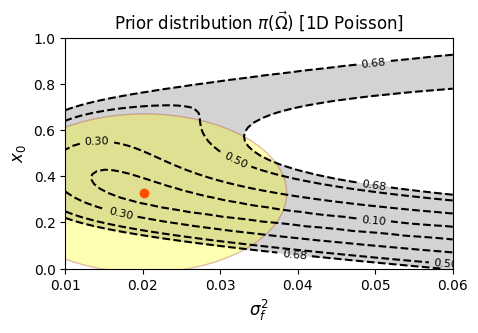

In [ ]:
#Visualizing the parameter prior distribution overlaid on the Highest Density Region

from matplotlib.patches import Ellipse

prob_flat = prob_grid.ravel()
pdf_sorted = np.sort(prob_flat)[::-1]
cumsum = np.cumsum(pdf_sorted)*dx0*dvar

level_value_list = []
level_list = [0.68, 0.5, 0.3, 0.1]
for level in level_list:
  level_idx = np.where(cumsum >= level)[0][0]
  level_value_list.append(pdf_sorted[level_idx])

label_dict = {lv: f"{cl:.2f}" for lv, cl in zip(level_value_list, level_list)}

# Contour plot of HDR and the parameter prior distribution
plt.figure(figsize=(5,3))
cs = plt.contour(P1, P2, prob_grid, levels=level_value_list, colors='black', linestyles='dashed')
plt.contourf(P1, P2, prob_grid, levels=[level_value_list[0], prob_grid.max()], colors=['lightgray'])
plt.scatter(var_vals[col],x0_vals[row], color ='r')
plt.clabel(cs, inline=True, fmt=label_dict, fontsize=8)

# Overlaying parameter prior distribution
eclipse = Ellipse((var_vals[col], x0_vals[row]), width=2*var_std, height=2*x0_std, edgecolor='brown', facecolor='yellow', alpha = 0.3)
ax = plt.gca()
ax.add_patch(eclipse)
ax.set_xlim(0.01, 0.06)
ax.set_ylim(0, 1)

plt.xlabel(r'$\sigma^2_f$', fontsize = 12)
plt.ylabel(r'$x_0$', fontsize = 12)
plt.title(r'Prior distribution $\pi(\vec{\Omega})$ [1D Poisson]')


##### Prior for the ODE residual's loss weight $\sigma^2_R$

In [ ]:
p_x_train = x_train[20:220]

initial_L_alpha, initial_L_beta, initial_L_nu, initial_L_pred = ini_nn_I(p_x_train)

initial_dL_dz = torch.autograd.grad(initial_L_pred, p_x_train,
                                  grad_outputs=torch.ones_like(initial_L_pred), create_graph=True)[0]

initial_grad2_L_dz = torch.autograd.grad(initial_dL_dz, p_x_train,
                                  grad_outputs=torch.ones_like(initial_L_pred), create_graph=True)[0]

# Converting to numpy objects for computing residual sum --------------------------------
njit_initial_grad2_L_dz = np.squeeze(initial_grad2_L_dz.detach().cpu().numpy())
n_x_train = np.squeeze(p_x_train.detach().cpu().numpy())
resi_sum = compute_z_array(x0_vals, var_vals, n_x_train, njit_initial_grad2_L_dz )

# Initial Likelihood Function (PDE residual) --------------------------------------------
resi_sum_array = np.sum(resi_sum, axis = -1)


In [ ]:
# Minimizing KL divergence between parameter prior and initial likelihood to determine initial $\sigma^2_R$ (eqn. 14)

def objective(variance_array):
    vari = variance_array[0]
    return kl_divergence_f(vari, resi_sum_array, x0_prior, variance_prior, 0)

optimal_beta = minimize(objective, x0=[1.], bounds=[(0.01, None)],method='Powell')

print(f"Optimal beta: {optimal_beta.x[0]:.4e}")

mean_var = optimal_beta.x[0]

Optimal beta: 4.0970e+01


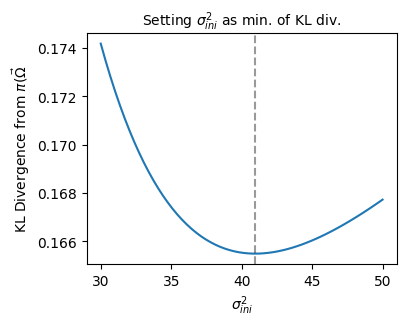

In [ ]:
#Plotting a graph to make sure that the optimization results make sense, i.e. 'mean_var' lies at the minimum point.

variance_vec = np.linspace(30,50,60)
kl_list = []
for var in variance_vec:
  kl_list.append(kl_divergence_f(var, resi_sum_array, x0_prior, variance_prior, 0))

plt.figure(figsize=(4,3))
plt.plot(variance_vec, kl_list)
plt.axvline(mean_var, color='k', linestyle='--', alpha = 0.4)
plt.xlabel(r"$\sigma^2_{ini}$")
plt.ylabel(r"KL Divergence from $\pi(\vec{\Omega}$")
plt.title(r'Setting $\sigma^2_{ini}$ as min. of KL div.',fontsize = 10)
plt.show()


In [ ]:
# Minimizing KL divergence between the minimal parameter prior and initial likelihood to determine minimum $\sigma^2_R$ (eqn. 15)

l_x0_std = x0_vals[2] - x0_vals[1]
l_x0_prior = (1/np.sqrt(2*3.14*l_x0_std**2))*np.exp(-1*(1/(2*l_x0_std**2))*(x0_vals - x0_prior_mean)**2)

l_var_std = var_vals[2] - var_vals[1]
l_variance_prior = (1/np.sqrt(2*3.14*l_var_std**2))*np.exp(-1*(1/(2*l_var_std**2))*(var_vals - var_prior_mean)**2)

def l_objective(variance_array):
    vari = variance_array[0]
    return kl_divergence_f(vari, resi_sum_array, l_x0_prior, l_variance_prior,
                                  np.finfo(float).tiny )

optimal_beta = minimize(l_objective, x0=[0.1], bounds=[(0.1, None)], method = 'Powell')

print(f"Optimal beta: {optimal_beta.x[0]:.4e}")

min_var = optimal_beta.x[0]

Optimal beta: 2.5739e-01


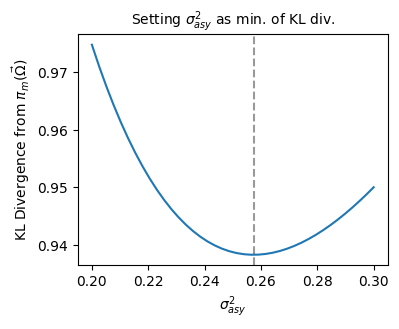

In [ ]:
#Plotting a graph to make sure that the optimization results make sense, i.e. 'min_var' lies at the minimum point.

variance_vec = np.linspace(0.2,0.3,40)
kl_list = []
for var in variance_vec:
  kl_list.append(kl_divergence_f(var, resi_sum_array, l_x0_prior, l_variance_prior,
                                np.finfo(float).tiny))

plt.figure(figsize=(4,3))
plt.plot(variance_vec, kl_list)
plt.axvline(min_var, color='k', linestyle='--', alpha = 0.4)
plt.xlabel(r"$\sigma^2_{asy}$")
plt.ylabel(r"KL Divergence from $\pi_m(\vec{\Omega}$)")
plt.title(r'Setting $\sigma^2_{asy}$ as min. of KL div.',fontsize = 10)
plt.show()

In [ ]:
# Solving for the prior of sigma_R using mean_var and min_var
# Obtaining alpha_r, beta_r from solving (14) and (16).

print(f'Mean_var: {mean_var:.3f}, Min_var: {min_var:.3f}')
eps_s = 2*min_var/(mean_var - min_var)
alpha_r = 1 + eps_s
beta_r = eps_s*mean_var
print(f'Alpha_r: {alpha_r:.3f}, Beta_r: {beta_r:.3f}')

Mean_var: 40.970, Min_var: 0.257
Alpha_r: 1.013, Beta_r: 0.518


In [ ]:
# Saving parameters of the two priors $\pi(\Omega)$ and $\pi(\sigma^2_R)$
Intermediate_Phase_Dict = {}
Intermediate_Phase_Dict['x0_prior_mean'] = x0_prior_mean
Intermediate_Phase_Dict['var_prior_mean'] = var_prior_mean
Intermediate_Phase_Dict['x0_std'] = x0_std
Intermediate_Phase_Dict['var_std'] = var_std
Intermediate_Phase_Dict['mean_var'] = mean_var
Intermediate_Phase_Dict['min_var'] = min_var
Intermediate_Phase_Dict['alpha_r'] = alpha_r
Intermediate_Phase_Dict['beta_r'] = beta_r

#torch.save(Intermediate_Phase_Dict, f'{MODEL_DIR}/poisson_Intermediate_Phase_Dict.pth')

### 2nd training phase: with complete loss function

#### initializing

In [ ]:
Intermediate_Phase_Dict = torch.load(f'{MODEL_DIR}/poisson_Intermediate_Phase_Dict.pth', weights_only=False)

In [ ]:
torch.manual_seed(137)
lr = 5e-4

# Initial values
x0_initial = Intermediate_Phase_Dict['x0_prior_mean']
var_initial = Intermediate_Phase_Dict['var_prior_mean']
mean_var = Intermediate_Phase_Dict['mean_var']
s_initial = torch.tensor(mean_var)
alpha_r = Intermediate_Phase_Dict['alpha_r']
beta_r = Intermediate_Phase_Dict['beta_r']


nn_I = FCN(1,16,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/ini_epinn_poisson.pth'))

# Defining various lists to collect various loss and parameter values
loss_list = []
data_loss_list = []
uncertainty_loss_list = []
pde_loss_list = []
s_list = []
x0_list = []
variance_list = []

x0_m = torch.nn.Parameter(torch.tensor(x0_initial, device=device, requires_grad=True))
variance_m = torch.nn.Parameter(torch.tensor(var_initial, device=device, requires_grad=True))
s = torch.nn.Parameter(torch.tensor(s_initial, device=device, requires_grad=True))

optimizer = optim.Adam([x0_m, variance_m, s] + list(nn_I.parameters()), lr=lr)


#### Model training

In [ ]:
# Training loop
n_D = x_train.shape[0]

for epoch in range(100_001):

    optimizer.zero_grad()

    #-----PDE Residual Loss---------------------------------
    L_p_alpha, L_p_beta, L_p_nu, L_pred = nn_I(x_train)
    dL_dz = torch.autograd.grad(L_pred, x_train, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]
    grad2_dL_dz = torch.autograd.grad(dL_dz, x_train, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]

    mse_physics_loss = torch.sum((grad2_dL_dz + torch.exp(-((x_train - x0_m)**2)/(2*variance_m)))**2)

    physics_loss = 0.5*(1/s)*mse_physics_loss
    physics_prior_loss = (alpha_r + 2/2)*torch.log(s) + beta_r/s

    #-----Data Loss-----------------------------------------
    data_loss = n_D*evidential_data_loss(L_pred, u_train, L_p_nu, L_p_alpha, L_p_beta)

    #-----Prior Loss----------------------------------------
    neg_ll_x0_prior = (1/(2*torch.tensor(x0_std)**2))*torch.mean((x0_m - torch.tensor(x0_prior_mean))**2)
    neg_ll_var_prior = (1/(2*torch.tensor(var_std)**2))*torch.mean((variance_m - torch.tensor(var_prior_mean))**2)

    #-----Total loss----------------------------------------
    loss = data_loss + physics_loss + physics_prior_loss + neg_ll_x0_prior + neg_ll_var_prior

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}, data: {data_loss.item():.5e}, PDE_L: {physics_loss.item():.5e} ")
        print(f"X0_m : {x0_m.item():.4e}, Var: {variance_m.item():.4e}, s:{s.item():.4e}")
        loss_list.append(loss.item())
        data_loss_list.append(data_loss.item())
        pde_loss_list.append(physics_loss.item())
        x0_list.append(x0_m.item())
        variance_list.append(variance_m.item())
        s_list.append(s.item())

In [ ]:
# saving model and other quantities
torch.save(nn_I.state_dict(), f'{MODEL_DIR}/final_epinn_poisson.pth')
torch.save({
    'loss_list': loss_list,
    'data_loss_list': data_loss_list,
    'pde_loss_list': pde_loss_list,
    'x0_list': x0_list,
    'variance_list': variance_list,
    's_list': s_list
}, f'{MODEL_DIR}/final_epinn_poisson_loss.pth')

### Analysis of results

In [ ]:
#Loading the saved final model
nn_I = FCN(1,16,2).to(device)
nn_I.load_state_dict(torch.load(f'{MODEL_DIR}/final_epinn_poisson.pth'))

checkpoint = torch.load(f'{MODEL_DIR}/final_epinn_poisson_loss.pth')
s_list = checkpoint['s_list']

#Loading parameters of the two priors $\pi(\Omega)$ and $\pi(\sigma^2_R)$
Intermediate_Phase_Dict = torch.load(f'{MODEL_DIR}/poisson_Intermediate_Phase_Dict.pth', weights_only = False)
x0_prior_mean = Intermediate_Phase_Dict['x0_prior_mean']
var_prior_mean = Intermediate_Phase_Dict['var_prior_mean']
x0_std = Intermediate_Phase_Dict['x0_std']
var_std = Intermediate_Phase_Dict['var_std']

Text(0, 0.5, 'Target variable $u$')

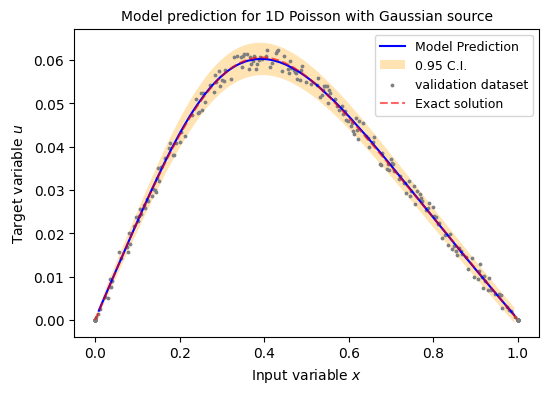

In [ ]:
n_val_x = np.squeeze(val_x.detach().cpu().numpy())
n_val_y = np.squeeze(val_data.detach().cpu().numpy())

Lp_alpha, Lp_beta, Lp_nu, L_pred = nn_I(val_x)
Lp_alpha = np.squeeze(Lp_alpha.detach().cpu().numpy())
Lp_beta = np.squeeze(Lp_beta.detach().cpu().numpy())
Lp_nu = np.squeeze(Lp_nu.detach().cpu().numpy())
L_pred = np.squeeze(L_pred.detach().cpu().numpy())

sort_idx = np.argsort(n_val_x)

n_val_x = n_val_x[sort_idx]
n_val_y = n_val_y[sort_idx]
Lp_alpha = Lp_alpha[sort_idx]
Lp_beta = Lp_beta[sort_idx]
Lp_nu = Lp_nu[sort_idx]
L_pred = L_pred[sort_idx]

interval_CI = 0.95
Llower = L_pred + CI_calculation(interval_CI, Lp_alpha, Lp_beta, Lp_nu, L_pred)
Lupper = L_pred - CI_calculation(interval_CI, Lp_alpha, Lp_beta, Lp_nu, L_pred)

n_x_train = np.squeeze(x_train.detach().cpu().numpy())
n_u_train = np.squeeze(u_train.detach().cpu().numpy())
#-----------------------------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(n_val_x, L_pred, color = 'b', label='Model Prediction')
plt.fill_between(n_val_x, Llower, Lupper, facecolor='orange', alpha=0.3, label = rf'{interval_CI} C.I.')
plt.scatter(n_x_train[:], n_u_train[:], c='gray',s=3, label="validation dataset")

plt.plot(x_total, u_exact_sol, 'r--', label="Exact solution",
         alpha=0.6)

plt.title(f"Model prediction for 1D Poisson with Gaussian source", fontsize = 10)
plt.legend(loc = 'upper right', fontsize=9)
plt.xlabel(r"Input variable $x$",fontsize=10)
plt.ylabel(r"Target variable $u$", fontsize=10)



Text(0.5, 1.0, 'Error Calibration Plot')

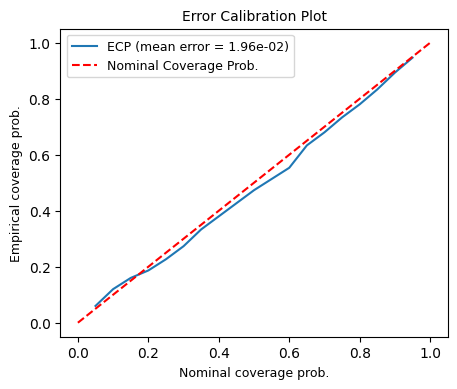

In [ ]:
#Empirical coverage probability

empirical_data = n_val_y

ecp_list = []
dis_list = []

for j in range(19):

  interval_CI = (j+1)*0.05

  neg_CI_delta = CI_calculation(interval_CI, Lp_alpha, Lp_beta ,
                                  Lp_nu, L_pred)

  acc=0
  for i in range(len(empirical_data)):
    if  np.abs(empirical_data[i] - L_pred[i])  < np.abs(neg_CI_delta[i]) :
      acc += 1

  empirical_ecp = acc/len(empirical_data)
  discrepancy = np.abs(empirical_ecp - interval_CI)

  dis_list.append(discrepancy)
  ecp_list.append(acc/len(empirical_data))

plt.figure(figsize=(5,4))
plt.plot(np.arange(0.05, 1.00, 0.05), np.array(ecp_list), label=f'ECP (mean error = {np.mean(dis_list):.2e})')
plt.plot([0,1],[0,1],'r--', label='Nominal Coverage Prob.')
plt.legend(fontsize = 9)
plt.xlabel('Nominal coverage prob.', fontsize=9)
plt.ylabel('Empirical coverage prob.', fontsize = 9)
plt.title('Error Calibration Plot', fontsize=10)

In [ ]:
#We take the final s value to be the variance $\sigma^2_R$ in the final likelihood function
s_mode = s_list[-1]

#Parameter domains
x0_vals = np.linspace(0.0, 1.0, 50)
var_vals = np.linspace(0.01, 0.06, 50)

#Prior distributions for the parameters
x0_prior = (1/np.sqrt(2*3.14*x0_std**2))*np.exp(-1*(1/(2*x0_std**2))*(x0_vals - x0_prior_mean)**2)
variance_prior = (1/np.sqrt(2*3.14*var_std**2))*np.exp(-1*(1/(2*var_std**2))*(var_vals - var_prior_mean)**2)

In [ ]:
Lp_alpha, Lp_beta, Lp_nu, L_pred = nn_I(x_train)
dL_dz = torch.autograd.grad(L_pred, x_train, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]
grad2_dL_dz = torch.autograd.grad(dL_dz, x_train, grad_outputs=torch.ones_like(L_pred), create_graph=True)[0]

Lp_alpha = Lp_alpha.detach().cpu().numpy()
Lp_beta = Lp_beta.detach().cpu().numpy()
Lp_nu = Lp_nu.detach().cpu().numpy()
L_pred = L_pred.detach().cpu().numpy()

njit_grad2_L_dz = np.squeeze(grad2_dL_dz.detach().cpu().numpy())

n_x_train = np.squeeze(x_train.detach().cpu().numpy())

resi_sum = compute_z_array(x0_vals, var_vals, n_x_train, njit_grad2_L_dz )

resi_sum_array = np.sum(resi_sum, axis = -1)

obj = njit_marginal_ll(s_mode, resi_sum_array)


@njit
def posterior_array(obj, x0_prior, variance_prior):
  posterior_init = np.empty((len(x0_vals), len(var_vals)))
  for i in range(len(x0_vals)):
    for j in range(len(var_vals)):
          posterior_init[i,j] = obj[i,j]*x0_prior[i]*variance_prior[j]
  return posterior_init


posterior_dis = posterior_array(obj, x0_prior, variance_prior)

In [ ]:
posterior_norm = posterior_dis / np.sum(posterior_dis)
x0_marginal = np.sum(posterior_norm, axis=(1))
x0_mean = np.sum(x0_vals * x0_marginal)
var_marginal = np.sum(posterior_norm, axis=(0))
var_mean = np.sum(var_vals * var_marginal)

posterior_flat = posterior_norm.ravel()
grid_shape = posterior_dis.shape

n_samples = 100_000
flat_indices = np.random.choice(len(posterior_flat), size=n_samples, p=posterior_flat)
multi_indices = np.array(np.unravel_index(flat_indices, grid_shape)).T

x0_samples = x0_vals[multi_indices[:, 0]]
var_samples = var_vals[multi_indices[:, 1]]

# Compute median and CI percentiles (e.g., 16th and 84th for 68% CI)
ci68 = lambda x: (np.percentile(x, 16), np.percentile(x, 84))

x0_ci68 = ci68(x0_samples)
var_ci68 = ci68(var_samples)

median_x0 = np.mean(x0_samples)
median_var = np.mean(var_samples)

In [ ]:
x0_68 = np.array(x0_ci68)
var_68 = np.array(var_ci68)
print(rf"Best-fit value and 68% C.I for $x_0$: {median_x0:.3f} with C.I. ({x0_68[0]:.3f}, {x0_68[1]:.3f})")
print(rf"Best-fit value and 68% C.I for $\sigma^2_f$: {median_var:.3f} with C.I. ({var_68[0]:.3f}, {var_68[1]:.3f})")

Best-fit value and 68% C.I for $x_0$: 0.334 with C.I. (0.327, 0.347)
Best-fit value and 68% C.I for $\sigma^2_f$: 0.021 with C.I. (0.018, 0.023)


In [ ]:
p_samples = 20_000

samples = np.column_stack([x0_samples[:p_samples], var_samples[:p_samples]])

f_samples = np.zeros([p_samples, len(z_monte)])

for i in range(p_samples):
  s_x0, s_var = samples[i]
  f_samples[i,:] = num_sol_poisson(s_x0, s_var, 300)

z_monte = np.linspace(0,1,300)
z_monte = torch.tensor(z_monte, dtype=torch.float32)
z_monte = z_monte.view(-1,1).requires_grad_(True)

Lp_alpha, Lp_beta, Lp_nu, L_pred = nn_I(z_monte)
L_monte_pred = L_pred.detach().cpu().numpy()

mean_f_samples = np.mean(f_samples, axis=0)

T_C = np.sum((np.squeeze(L_monte_pred) - mean_f_samples)**2)

T_samples = np.sum((f_samples - mean_f_samples[None, :]) ** 2, axis=1)

p_value = np.mean(T_samples >= T_C)

print(f"p-value indicating plausibility of model realizing prior distribution of parameters: {p_value}")

p-value indicating plausibility of model realizing prior distribution of parameters: 0.88185


In [ ]:
#Plotting posterior distributions and marginal distributions
X, Y = np.meshgrid(var_vals, x0_vals)

sorted_post = np.sort(posterior_norm.ravel())[::-1]
cumulative = np.cumsum(sorted_post)

level_68 = sorted_post[np.searchsorted(cumulative, 0.68)]
level_95 = sorted_post[np.searchsorted(cumulative, 0.95)]

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].contour(X, Y, posterior_norm, levels=[level_95, level_68], colors=['blue', 'red'])
axes[0].scatter(median_var, median_x0, color='black', marker='*',
                label='Model prediction')
axes[0].scatter(0.02, 0.33, color='green', marker='o', label='actual values')

axes[0].set_title(r'68%, 95% Confidence Contours', fontsize = 9)
axes[0].set_xlim(0.01, 0.03)
axes[0].set_ylim(0.3, 0.4)
axes[0].set_xlabel(r'$\sigma^2_f$')
axes[0].set_ylabel(r'$x_0$')
axes[0].legend(fontsize=9)

axes[1].plot(x0_vals, x0_marginal, 'k--')
axes[1].set_xlabel(r'$x_0$')
axes[1].set_title(r'Marginal density of $x_0$', fontsize = 10)

axes[2].plot(var_vals, var_marginal, 'k--')
axes[2].set_xlabel(r'$\sigma^2_f$')
axes[2].set_title(r'Marginal density of $\sigma^2_f$', fontsize = 10)

plt.tight_layout()
